In [1]:
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import requests
from tqdm.auto import tqdm
from rectools import Columns
from matplotlib import pyplot as plt

In [2]:
np.random.seed(23)

# Метрики

## Get KION dataset

In [3]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'

In [4]:
req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [5]:
#!unzip kion.zip

In [6]:
import zipfile as zf

files = zf.ZipFile('kion.zip','r')
files.extractall()
files.close()

## Read data

In [7]:
interactions = pd.read_csv('data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    },
    inplace=True)

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [8]:
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [9]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [10]:
interactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


Выделим небольшой кусок из данных, чтобы не слишком страдать

In [11]:
sample_users = [57607, 403227, 70720]
df = interactions[interactions[Columns.User].isin(sample_users)].reset_index(drop=True)
del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
df

,user_id,item_id
0,70720,4880
1,57607,4151
2,57607,10440
3,70720,4881
4,403227,6353
5,403227,1736
6,70720,6327
7,57607,13865
8,403227,5336
9,403227,181


In [12]:
print('Users', df[Columns.User].unique())
sample_items = df[Columns.Item].unique()
print('Items', sample_items)

Users [ 70720  57607 403227]
Items [ 4880  4151 10440  4881  6353  1736  6327 13865  5336   181]


## Naive vs Numba vs Pandas

In [13]:
df

,user_id,item_id
0,70720,4880
1,57607,4151
2,57607,10440
3,70720,4881
4,403227,6353
5,403227,1736
6,70720,6327
7,57607,13865
8,403227,5336
9,403227,181


In [14]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']

    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [15]:
def mrr_naive(target, users, recs):
    mrr = []
    for i, user in enumerate(users):
        r = 0
        user_target = target[target[:, 0] == user][:, 1]
        for j in range(len(recs[i])):
            if recs[i][j] in user_target:
                r = j + 1
                break
        if r == 0:
            mrr.append(0)
        else:
            mrr.append(1 / r)
    return sum(mrr) / len(users)

In [16]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target, users, recs):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        r = 0
        user_target = target[target[:, 0] == user][:, 1]
        for j in nb.prange(len(recs[i])):
            if recs[i][j] in user_target:
                r = j + 1
                break
        if r == 0:
            mrr[i] = 0
        else:
            mrr[i] = 1 / r
    return mrr.mean()

In [17]:
def mrr_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    rank = df_recs.groupby(Columns.User)[Columns.Rank].agg('min')

    mrr = (1/rank).sum() / len(rank)
    return mrr

In [18]:
users_count_list = [100, 1000, 10000, 100000]
top_k_list = [10, 50, 100]
data = {'users': [], 'top_k': [], 'naive': [], 'numba': [], 'pandas': []}
for user_count, top_k in product(users_count_list, top_k_list):
    print("Users: ", user_count, " Top k: ", top_k)

Users:  100  Top k:  10
Users:  100  Top k:  50
Users:  100  Top k:  100
Users:  1000  Top k:  10
Users:  1000  Top k:  50
Users:  1000  Top k:  100
Users:  10000  Top k:  10
Users:  10000  Top k:  50
Users:  10000  Top k:  100
Users:  100000  Top k:  10
Users:  100000  Top k:  50
Users:  100000  Top k:  100


In [19]:
users_count_list = [100, 1000, 10000, 100000]
top_k_list = [10, 50, 100]
data = {'users': [], 'top_k': [], 'naive': [], 'numba': [], 'pandas': []}
for user_count, top_k in product(users_count_list, top_k_list):
    print("Users: ", user_count, " Top k: ", top_k)
    df, users, recs = generate_subsample(user_count, top_k)
    data['users'].append(user_count)
    data['top_k'].append(top_k)

    print("Naive calculating...")
    result_naive = %timeit -n 10 -o mrr_naive(df.values, users, recs)

    if user_count == 100 and top_k == 10:
        %timeit -n 10 -o mrr_numba(df.values, users, recs)     # warming-up
    print("Numba calculating...")
    result_numba = %timeit -n 10 -o mrr_numba(df.values, users, recs)
    print("Pandas calculating...")
    result_pandas = %timeit -n 10 -o mrr_pandas(df, users, recs, top_k)

    data['naive'].append(np.mean(result_naive.all_runs))
    data['numba'].append(np.mean(result_numba.all_runs))
    data['pandas'].append(np.mean(result_pandas.all_runs))

Users:  100  Top k:  10
Naive calculating...
3.91 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 284.67 times longer than the fastest. This could mean that an intermediate result is being cached.
2.14 ms ± 5.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numba calculating...
55.2 µs ± 4.61 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Pandas calculating...
3.45 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Users:  100  Top k:  50
Naive calculating...
8.06 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numba calculating...
78.2 µs ± 9.32 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Pandas calculating...
3.64 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Users:  100  Top k:  100
Naive calculating...
11.7 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numba calculating...
86.9 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Pa

In [20]:
data = pd.DataFrame(data)
data

,users,top_k,naive,numba,pandas
0,100,10,0.039061,0.000552,0.034500
1,100,50,0.080573,0.000782,0.036390
2,100,100,0.116636,0.000869,0.044772
3,1000,10,0.370410,0.039568,0.048975
4,1000,50,0.890298,0.038236,0.073963
5,1000,100,1.396278,0.036715,0.111090
6,10000,10,12.469248,3.950357,0.204412
7,10000,50,18.268735,4.207087,0.572581
8,10000,100,22.407984,3.887054,1.203879
9,100000,10,982.295030,384.617979,2.502535


In [21]:
users_groups = data.groupby('users')
top_k_groups = data.groupby('top_k')

In [22]:
for i, (k, g) in enumerate(users_groups):
    print(g)

   users  top_k     naive     numba    pandas
0    100     10  0.039061  0.000552  0.034500
1    100     50  0.080573  0.000782  0.036390
2    100    100  0.116636  0.000869  0.044772
   users  top_k     naive     numba    pandas
3   1000     10  0.370410  0.039568  0.048975
4   1000     50  0.890298  0.038236  0.073963
5   1000    100  1.396278  0.036715  0.111090
   users  top_k      naive     numba    pandas
6  10000     10  12.469248  3.950357  0.204412
7  10000     50  18.268735  4.207087  0.572581
8  10000    100  22.407984  3.887054  1.203879
     users  top_k        naive       numba     pandas
9   100000     10   982.295030  384.617979   2.502535
10  100000     50  1044.300481  390.148317  10.385360
11  100000    100  1096.303739  390.333297  19.684208


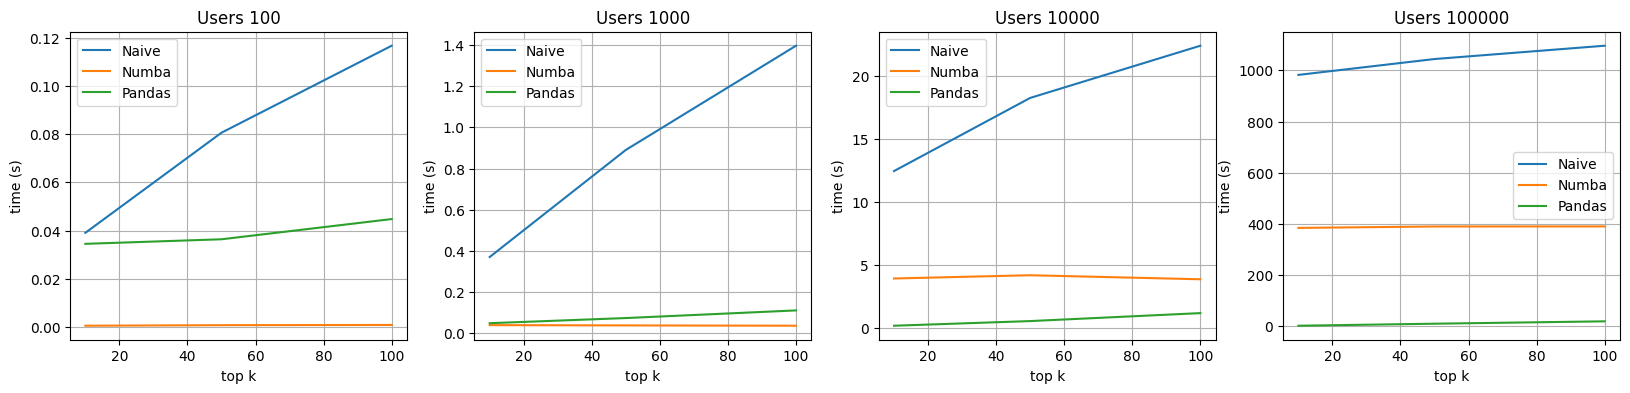

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, (k, g) in enumerate(users_groups):
    axs[i].plot(g['top_k'], g['naive'], label='Naive')
    axs[i].plot(g['top_k'], g['numba'], label='Numba')
    axs[i].plot(g['top_k'], g['pandas'], label='Pandas')
    axs[i].set_xlabel('top k')
    axs[i].set_ylabel('time (s)')
    axs[i].set_title(f'Users {k}')
    axs[i].legend()
plt.show()

В силу того, что количество рекомендаций в целом не особенно большое, то изменение их числа скорее влияет на вычеслительные мощности при малом количестве юзеров. Чем больше юзеров, тем, как видно, разница между влияением разного количества рекомендаций несущественная. Но и разница в порядках чисел (количества рекомендаций и количества юзеров) явно очень большая.

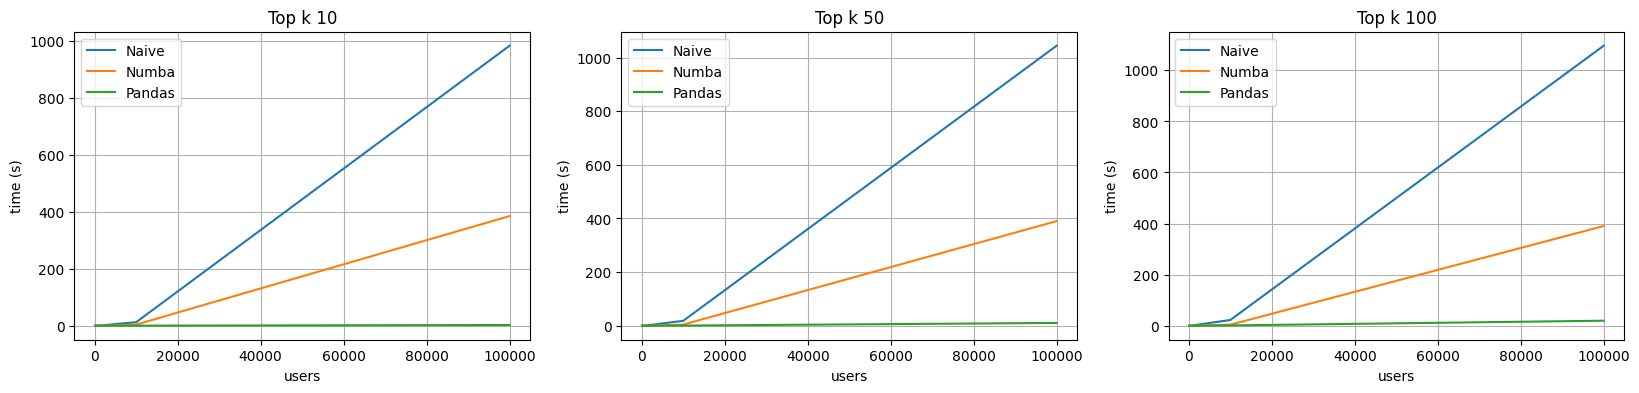

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
for i, (k, g) in enumerate(top_k_groups):
    axs[i].plot(g['users'], g['naive'], label='Naive')
    axs[i].plot(g['users'], g['numba'], label='Numba')
    axs[i].plot(g['users'], g['pandas'], label='Pandas')
    axs[i].set_xlabel('users')
    axs[i].set_ylabel('time (s)')
    axs[i].set_title(f'Top k {k}')
    axs[i].legend()
plt.show()

Это же можно увидеть и на графике при статичном количестве рекомендаций, по крайней мере на этих примерах видно, как линейно возрастает время расчета при любом топ рекомендаций с увеличением юзеров.